# Correlation of text content across documents

## 1. Setup
To prepare your environment, you need to install some packages and enter credentials for the Watson services.

### 1.1 Install the necessary packages

You need the latest versions of these packages:<br>
Watson Developer Cloud: a client library for Watson services.<br>
NLTK: leading platform for building Python programs to work with human language data.<br>
python-keystoneclient: is a client for the OpenStack Identity API.<br>
python-swiftclient: is a python client for the Swift API.<br><br>
** Install the Watson Developer Cloud package: **

In [ ]:
!pip install --upgrade watson-developer-cloud

** Install NLTK: **

In [ ]:
!pip install --upgrade nltk

** Install IBM Cloud Object Storage Client: **

In [ ]:
!pip install ibm-cos-sdk

** <font color=blue>Now restart the kernel by choosing Kernel > Restart. </font> **

### 1.2 Import packages and libraries

Import the packages and libraries that you'll use:

In [ ]:
import json
import sys
import thread
import time
import watson_developer_cloud
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 \
  import Features, EntitiesOptions, KeywordsOptions,SemanticRolesOptions
    
import ibm_boto3
from botocore.client import Config
    
import operator
from functools import reduce
from io import StringIO
import numpy as np
from os.path import join, dirname
import requests
import re
import pandas as pd
import nltk
from nltk.cluster.util import cosine_distance
from nltk import word_tokenize,sent_tokenize,ne_chunk
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
import numpy

## 2. Configuration

Add configurable items of the notebook below

### 2.1 Add your service credentials from IBM Cloud for the Watson services

You must create a Watson Natural Language Understanding service on IBM Cloud.
Create a service for Natural Language Understanding (NLU).
Insert the username and password values for your NLU in the following cell. Do not change the values of the version fields.

Run the cell.

In [ ]:
# @hidden_cell
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='',
    username="",
    password="")

### 2.2 Add your service credentials for Object Storage

You must create Object Storage service on IBM Cloud.
To access data in a file in Object Storage, you need the Object Storage authentication credentials.
Insert the Object Storage authentication credentials in the following cell. 


In [ ]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IBM_API_KEY_ID': '',
    'IAM_SERVICE_ID': '',
    'ENDPOINT': '',
    'IBM_AUTH_ENDPOINT': '',
    'BUCKET': '',
    'FILE': ''
}

### 2.3 Global Variables

Add global variables.


In [ ]:
# Specify file names for sample text and configuration files
sampleTextFileName1 = "sample_text_1.txt"
sampleTextFileName2 = "sample_text_2.txt"
sampleConfigFileName = "sample_config.txt"

# Maintain tagged text and plain text map
tagTextMap ={}

# Stop words
nltk.download('stopwords')
stopWords = stopwords.words('english')
# Additional words to be ignored 
stopWords.extend(["The","This","That",".","!","?"])

### 2.4 Configure and download required NLTK packages

Download the 'punkt' and 'averaged_perceptron_tagger' NLTK packages for POS tagging usage.

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

## 3. Correlation

Write the correlation related utility functions in a modularalized form.

### 3.1 Watson NLU API

In [ ]:
def analyze_using_NLU(analysistext):
    response = natural_language_understanding.analyze( 
        text=analysistext,
        features=Features(entities=EntitiesOptions(), 
                          keywords=KeywordsOptions(),
                          semantic_roles=SemanticRolesOptions()))

    return response

### 3.2 Augumented Correlation

Custom correlation utlity fucntions for augumenting the results of Watson NLU API call

In [ ]:
def split_sentences(text):
    """ Split text into sentences.
    """
    sentence_delimiters = re.compile(u'[\\[\\]\n.!?]')
    sentences = sentence_delimiters.split(text)
    return sentences

def split_into_tokens(text):
    """ Split text into tokens.
    """
    tokens = nltk.word_tokenize(text)
    return tokens
    
def POS_tagging(text):
    """ Generate Part of speech tagging of the text.
    """
    POSofText = nltk.tag.pos_tag(text)
    return POSofText

def keyword_tagging(tag,tagtext,text):
    """ Tag the text matching keywords.
    """
    if (text.lower().find(tagtext.lower()) != -1):
        return text[text.lower().find(tagtext.lower()):text.lower().find(tagtext.lower())+len(tagtext)]
    else:
        return 'UNKNOWN'
    
def regex_tagging(tag,regex,text):
    """ Tag the text matching REGEX.
    """    
    p = re.compile(regex, re.IGNORECASE)
    matchtext = p.findall(text)
    regex_list=[]    
    if (len(matchtext)>0):
        for regword in matchtext:
            regex_list.append(regword)
    return regex_list

def chunk_tagging(tag,chunk,text):
    """ Tag the text using chunking.
    """
    parsed_cp = nltk.RegexpParser(chunk)
    pos_cp = parsed_cp.parse(text)
    chunk_list=[]
    for root in pos_cp:
        if isinstance(root, nltk.tree.Tree):               
            if root.label() == tag:
                chunk_word = ''
                for child_root in root:
                    chunk_word = chunk_word +' '+ child_root[0]
                chunk_list.append(chunk_word)
    return chunk_list
    
def augument_NLUResponse(responsejson,updateType,text,tag):
    """ Update the NLU response JSON with augumented classifications.
    """
    if(updateType == 'keyword'):
        if not any(d.get('text', None) == text for d in responsejson['keywords']):
            responsejson['keywords'].append({"text":text,"relevance":0.5})
    else:
        if not any(d.get('text', None) == text for d in responsejson['entities']):
            responsejson['entities'].append({"type":tag,"text":text,"relevance":0.5,"count":1})        
    
def chunk_sentence(text):
    """ Tag the sentence using chunking.
    """
    grammar = """
      NP: {<DT|JJ|PRP|NN.*>+} # Chunk sequences of DT,JJ,NN
          #}<VB*|DT|JJ|RB|PRP><NN.*>+{  # Chink sequences of VB,DT,JJ,NN       
      PP: {<IN><NP>}               # Chunk prepositions followed by NP
      V: {<V.*>}                   # Verb      
      VP: {<VB*><NP|PP|CLAUSE>+}  # Chunk verbs and their arguments
      CLAUSE: {<NP><VP>}           # Chunk NP, VP
      """  
    parsed_cp = nltk.RegexpParser(grammar,loop=2)
    pos_cp = parsed_cp.parse(text)
    return pos_cp
    
def find_attrs(subtree,phrase):
    attrs = ''
    if phrase == 'NP':
        for nodes in subtree:
            if nodes[1] in ['DT','PRP$','POS','JJ','CD','ADJP','QP','NP','NNP']:
                attrs = attrs+' '+nodes[0]
    return attrs    
    
def find_subject(t):
    for s in t.subtrees(lambda t: t.label() == 'NP'):
        return find_attrs(s,'NP')
    
def resolve_coreference(text, config):
    """ Resolve coreferences in the text for Nouns that are Subjects in a sentence
    """
    sentenceList = split_sentences(text)
    referenceSubject = ''
    sentenceText = ''
    configjson = json.loads(config)
    
    for sentences in sentenceList:    
        tokens = split_into_tokens(sentences)   
        postags = POS_tagging(tokens)
        sentencetags = chunk_sentence(postags)
        subjects = find_subject(sentencetags)
        for rules in configjson['configuration']['coreference']['rules']:
            if (rules['type'] == 'chunking'):
                for tags in rules['chunk']:
                    chunktags = chunk_tagging(tags['tag'],tags['pattern'],postags)
                    if (len(chunktags)>0):
                        for words in chunktags:
                            if tags['tag'] == 'PRP':
                                if subjects == '':
                                    sentenceText = sentenceText+sentences.replace(words,referenceSubject)+'. '
                            elif tags['tag'] == 'NAME':
                                if words == subjects:
                                    referenceSubject = words
                                    sentenceText = sentenceText+sentences+'. '
                    
    return sentenceText

def disambiguate_entities(text):
    """ Resolve disambiguity in the text using entities and entity resolution performed using Watson NLU
    """    
    sentenceList = split_sentences(text)
    taggedtext = text
    response = analyze_using_NLU(text)
    responsejson = response
    for sentences in sentenceList:
        tokens = split_into_tokens(sentences)
        postags = POS_tagging(tokens)
        name_tagged_text = chunk_tagging('NAME','NAME:{<NNP>+}',postags)
        print(name_tagged_text)
    for entities in responsejson['entities']:
        regexstr = entities['text']+'(?!>)'
        regex = re.compile(regexstr, re.IGNORECASE)
        tagText = '<'+entities['type']+':'+entities['text']+'>'
        taggedtext = re.sub(regexstr,tagText,taggedtext)
        tagTextMap[tagText] = entities['text']
    
    for roles in responsejson['semantic_roles']:
        if 'entities' not in roles['subject']:
            print('NO ENTITY')
        else:
            for entity in roles['subject']['entities']:
                if 'disambiguation' not in entity:
                    print('NO DISAMBIGUATION')
                else:
                    regexstr = roles['subject']['text']+'(?!>)'
                    regex = re.compile(regexstr, re.IGNORECASE)
                    tagText = '<'+entity['type']+':'+entity['text']+'>'
                    taggedtext = re.sub(regexstr,tagText,taggedtext)
                    tagTextMap[tagText] = entity['text']
    
    return taggedtext

def extract_relations(text, config,relations):
    """ Extract entity relationships in a sentence
    """    
    sentenceList = split_sentences(text)
    configjson = json.loads(config)
     
    for sentences in sentenceList:
        for rules in configjson['configuration']['relations']['rules']:
            if (rules['type'] == 'd_regex'):
                for regex in rules['d_regex']:
                    regextags = regex_tagging(regex['tag'],regex['pattern'],sentences)
                    if (len(regextags)>0):
                        for words in regextags:
                            relations.append((tagTextMap[words[0]],regex['tag'],tagTextMap[words[2]]))
         
    return relations

def compute_text_similarity(text1, text2, text1tags, text2tags):
    """ Compute text similarity using cosine
    """
    sentences_text1 = split_sentences(text1)
    sentences_text2 = split_sentences(text2)
    tokens_text1 = []
    tokens_text2 = []
    
    for sentence in sentences_text1:
        tokenstemp = split_into_tokens(sentence.lower())
        tokens_text1.extend(tokenstemp)
    
    for sentence in sentences_text2:
        tokenstemp = split_into_tokens(sentence.lower())
        tokens_text2.extend(tokenstemp)
    # Add text tags    
    if (len(text1tags) > 0):  
        tokens_text1.extend(text1tags)
    if (len(text2tags) > 0):    
        tokens_text2.extend(text2tags)
    
    # Stem words
    tokens1Filtered = [stemmer.stem(x) for x in tokens_text1 if x not in stopWords]
    tokens2Filtered = [stemmer.stem(x) for x in tokens_text2 if x not in stopWords]
    
    #  remove duplicate tokens
    tokens1Filtered = set(tokens1Filtered)
    tokens2Filtered = set(tokens2Filtered)
   
    tokensList=[]

    text1vector = []
    text2vector = []

    if len(tokens1Filtered) < len(tokens2Filtered):
        tokensList = tokens1Filtered
    else:
        tokensList = tokens2Filtered

    for token in tokensList:
        if token in tokens1Filtered:
            text1vector.append(1)
        else:
            text1vector.append(0)
        if token in tokens2Filtered:
            text2vector.append(1)
        else:
            text2vector.append(0)  

    cosine_similarity = 1-cosine_distance(text1vector,text2vector)
    if numpy.isnan(cosine_similarity):
        cosine_similarity = 0
    
    return cosine_similarity

### 3.3 Correlated Network Visualization

Utility function to plot network visualization of entity relationships to correlate them

In [ ]:
def draw_simple_graph(graph):

    nodes = []
    labels = []
    edges = []
    # extract nodes from graph
    for tuples in graph:
        nodes.append(tuples[0])
        nodes.append(tuples[2])
        
    # extract edges from graph
    for edgepairs in graph:
        edges.append((edgepairs[0],edgepairs[2]))        
    # extract edge labels from graph
    for edgetuples in graph:
        labels.append(edgetuples[1])
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[2])

    # draw graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos,with_labels = True)
    edge_labels = dict(zip(edges, labels))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)

    # show graph
    plt.show()    

## 4. Persistence and Storage

### 4.1 Configure Object Storage Client

In [ ]:
cos = ibm_boto3.client('s3',
                    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                    config=Config(signature_version='oauth'),
                    endpoint_url=credentials_1['ENDPOINT'])

def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_1['BUCKET'], Key=filename)['Body']
    return fileobject

def load_string(fileobject):
    '''Load the file contents into a Python string'''
    text = fileobject.read()
    return text

## 5. Correlate text
Read the data files for correlation from Object Store<br>
Read the configuration file for rules of coreference and correlation from Object Store.<br>

In [ ]:
text1 = load_string(get_file(sampleTextFileName1))
text2 = load_string(get_file(sampleTextFileName2))
config = load_string(get_file(sampleConfigFileName))

relationships = []

resolved_text1 = resolve_coreference(text1, config)
resolved_text2 = resolve_coreference(text2, config)

disambiguated_text1 = disambiguate_entities(resolved_text1)
disambiguated_text2 = disambiguate_entities(resolved_text2)

extract_relations(disambiguated_text1, config,relationships)
extract_relations(disambiguated_text2, config,relationships)

In [ ]:
print "Document similarity score" 
print compute_text_similarity(text1,text2,[],[])
print ""
print "Entities and relations:"
print relationships

## 6. Visualize correlated text
Load correlated text into Networkx<br>
Plot network graph of the correlated text.<br>

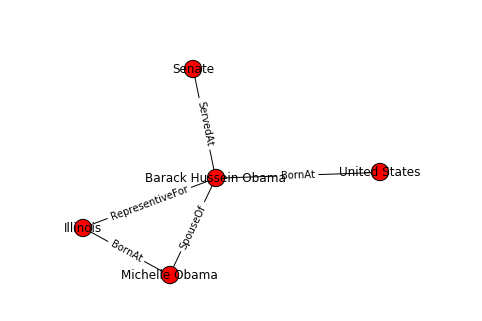

In [19]:
draw_simple_graph(relationships)